<a href="https://colab.research.google.com/github/Sahaswari/Brain-Tumor-Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets -q
!pip install gradio

In [ ]:
import pandas as pd
import gradio as gr
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import time

import opendatasets as od
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
od.download("https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sahaswarisamoda
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri


100%|██████████| 86.8M/86.8M [00:01<00:00, 63.7MB/s]


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224,224)

In [ ]:
train_data_dir = "/content/brain-tumor-classification-mri/Training"
test_data_dir = "/content/brain-tumor-classification-mri/Testing"

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE,
    subset='training',
    validation_split=0.1,
    seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE,
    subset='validation',
    validation_split=0.1,
    seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    batch_size=BATCH_SIZE,
    image_size = IMAGE_SIZE)

Found 2870 files belonging to 4 classes.
Using 2583 files for training.
Found 2870 files belonging to 4 classes.
Using 287 files for validation.
Found 394 files belonging to 4 classes.


In [ ]:
types = train_data.class_names
types

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
for image_batch, label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 224, 224, 3)
(32,)


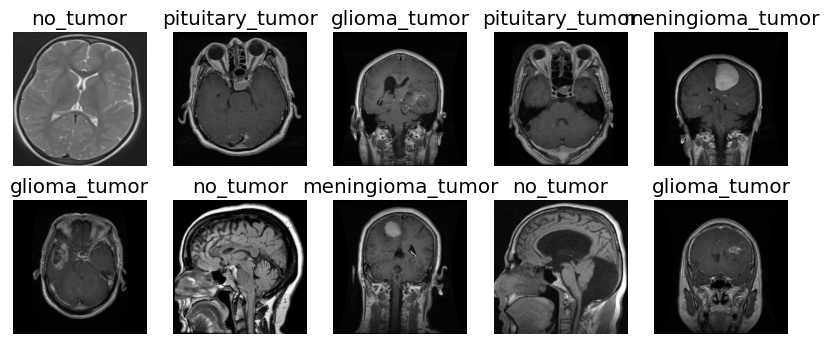

In [ ]:
#plot data
plt.figure(figsize=(10,4))
for image, label in train_data.take(1):
  for i in range(10):
    ax = plt.subplot(2,5,i+1)
    plt.imshow(image[i].numpy().astype('uint8'))
    plt.title(types[label[i]])
    plt.axis('off')

In [ ]:
#data visulaization
for image, label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [ ]:
#Data Prepositing
#Data Normalization
train_data = train_data.map(lambda x, y:(x/255,y))
validation_data = validation_data.map(lambda x, y:(x/255,y))
test_data = test_data.map(lambda x, y:(x/255,y))

In [ ]:
for image, label in train_data.take(1):
  for i in range(1):
    print(image)

tf.Tensor(
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.00410162 0.00410162 0.00410162]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.      

In [ ]:
#Data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal",input_shape=(224,224,3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2)
    ]
)

In [ ]:
#build model Architecture
model = tf.keras.models.Sequential()

model.add(data_augmentation)

model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, kernel_size=3, activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.Dense(32, activation = 'relu'))

model.add(tf.keras.layers.Dense(4,activation = 'softmax'))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)      

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
start_time = time.time()
history = model.fit(train_data,
                    epochs = 5,
                    validation_data = validation_data)
end_time = time.time()
print(end_time - start_time)

Epoch 1/5
81/81 [==============================] - 352s 4s/step - loss: 1.2818 - accuracy: 0.5029 - val_loss: 1.3647 - val_accuracy: 0.1916
Epoch 2/5
81/81 [==============================] - 330s 4s/step - loss: 0.9668 - accuracy: 0.5885 - val_loss: 1.2295 - val_accuracy: 0.3902
Epoch 3/5
81/81 [==============================] - 334s 4s/step - loss: 0.9162 - accuracy: 0.6082 - val_loss: 1.2471 - val_accuracy: 0.3415
Epoch 4/5
81/81 [==============================] - 328s 4s/step - loss: 0.8646 - accuracy: 0.6229 - val_loss: 1.2597 - val_accuracy: 0.3798
Epoch 5/5
81/81 [==============================] - 320s 4s/step - loss: 0.7950 - accuracy: 0.6508 - val_loss: 1.1102 - val_accuracy: 0.5192
1769.9529752731323


In [ ]:
history.history

{'loss': [1.2817671298980713,
  0.9667811989784241,
  0.9162089228630066,
  0.8645970225334167,
  0.7949915528297424],
 'accuracy': [0.5029035806655884,
  0.5884630084037781,
  0.6082075238227844,
  0.6229190826416016,
  0.6507936716079712],
 'val_loss': [1.3647156953811646,
  1.2295119762420654,
  1.2471317052841187,
  1.2597075700759888,
  1.110164999961853],
 'val_accuracy': [0.19163763523101807,
  0.39024388790130615,
  0.3414634168148041,
  0.37979093194007874,
  0.5191637873649597]}

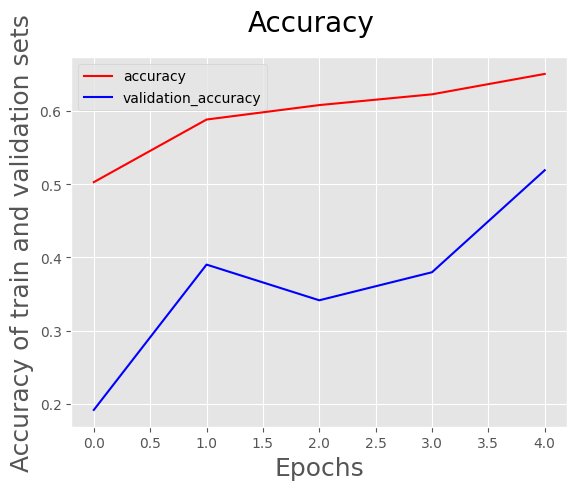

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color = 'red', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='validation_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Accuracy of train and validation sets', fontsize = 18)
plt.legend()
plt.show()

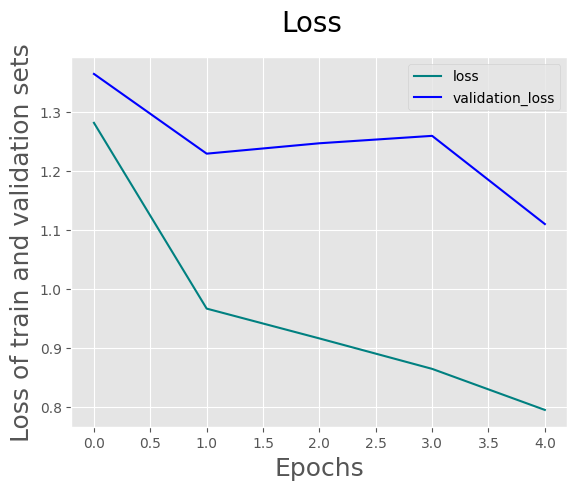

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color = 'teal', label='loss')
plt.plot(history.history['val_loss'], color = 'blue', label='validation_loss')
fig.suptitle('Loss', fontsize = 20)
plt.xlabel('Epochs', fontsize = 18)
plt.ylabel('Loss of train and validation sets', fontsize = 18)
plt.legend()
plt.show()

In [ ]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.Accuracy()

In [ ]:
#Check process for the Test data
for batch in test_data.as_numpy_iterator():
  x,y = batch
  yhat = model.predict(x)
  yhat = np.argmax(yhat, axis=1) # Convert predicted probabilities to class indices
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 361ms/step


In [ ]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.77557755>

In [ ]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.79931974>

In [ ]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.3426396>

In [ ]:
import cv2

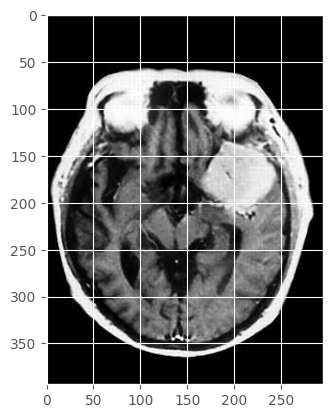

In [ ]:
image = cv2.imread('/content/brain-tumor-classification-mri/Testing/meningioma_tumor/image(107).jpg')
plt.imshow(image)
plt.show()

In [ ]:
resized_image = tf.image.resize(image, IMAGE_SIZE)
scaled_image = resized_image/255

In [ ]:
scaled_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>

In [ ]:
np.expand_dims(scaled_image, axis=0).shape

(1, 224, 224, 3)

In [ ]:
y_hat = model.predict(np.expand_dims(scaled_image, axis=0))

1/1 [==============================] - 0s 121ms/step


In [ ]:
y_hat

array([[0.04919186, 0.40518337, 0.38764167, 0.15798308]], dtype=float32)

In [ ]:
types

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
model.save('model_inception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Step 6: Create Gradio Interface
def classify_image(image):
    image = image.resize((224, 224))
    image = np.array(image) / 255.0
    image = image.reshape((1, 224, 224, 3))
    prediction = model.predict(image)
    class_names = train_data.class_names
    return {class_names[i]: float(prediction[0][i]) for i in range(4)}

In [ ]:
import gradio as gr
interface = gr.Interface(
    classify_image,
    gr.Image(),  # Use gr.inputs.Image
    gr.Label(num_top_classes=4), # Use gr.outputs.Label
)

In [ ]:
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e1cdeb8305b0ec6381.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the model (make sure to update the path to your model)
model = tf.keras.models.load_model('model_inception.h5')

# Define the classification function
def classify_image(img):
    img = img.resize((224, 224))  # Resize the image to match the model's input size
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image

    predictions = model.predict(img)
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

    # Create a dictionary of the class names and their probabilities
    result = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    return result

# Create the Gradio interface
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=4),
    title="Brain Tumor Classification",
    description="Upload a brain MRI image to classify the type of tumor."
)

# Launch the interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://407db0c1695adc5e50.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the model
model = tf.keras.models.load_model('model_inception.h5')

# Define the classification function
def classify_image(img):
    img_resized = img.resize((224, 224))  # Resize the image to match the model's input size
    img_array = image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image

    predictions = model.predict(img_array)
    class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

    # Create a dictionary of the class names and their probabilities
    result = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    return img, result

# Create the Gradio interface with custom styling
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil", label="Upload a Brain MRI Image"),
    outputs=[
        gr.Image(label="Input Image"),
        gr.Label(num_top_classes=4, label="Classification Results")
    ],
    title="Brain Tumor Classification",
    description="Upload a brain MRI image to classify the type of tumor.",
    theme="default",  # Using default theme as huggingface theme is not available
    css="""
    .gradio-container {
        border: 5px solid #4CAF50; /* Green border */
        border-radius: 10px; /* Rounded corners */
        padding: 20px;
        background-color: #f0f0f0; /* Light grey background */
    }
    .gradio-title {
        color: #4CAF50; /* Green text for the title */
        font-size: 2em;
        font-weight: bold;
    }
    .gradio-description {
        color: #333; /* Darker text for the description */
        font-size: 1.2em;
    }
    .gradio-label {
        font-size: 1.1em;
        color: #333;
        font-weight: bold;
    }
    .gradio-image {
        border: 2px solid #4CAF50; /* Green border for images */
        border-radius: 5px; /* Slightly rounded corners */
    }
    """
)

# Launch the interface
interface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://e418e06a8eef1cac84.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the model
model = tf.keras.models.load_model('model_inception.h5')

# Define the classification function
def classify_images(imgs):
    results = []
    for img in imgs:
        img_resized = img.resize((224, 224))  # Resize the image to match the model's input size
        img_array = image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0  # Normalize the image

        predictions = model.predict(img_array)
        class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

        # Create a dictionary of the class names and their probabilities
        result = {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
        results.append((img, result))
    return results

# Create the Gradio interface with custom styling
interface = gr.Interface(
    fn=classify_images,
    inputs=gr.inputs.Image(type="pil", label="Upload Brain MRI Images", multiple=True),
    outputs=[
        gr.outputs.Image(label="Input Image"),
        gr.outputs.Label(num_top_classes=4, label="Classification Results")
    ],
    title="Brain Tumor Classification",
    description="Upload brain MRI images to classify the type of tumor.",
    css="""
    .gradio-container {
        border: 5px solid #4CAF50; /* Green border */
        border-radius: 10px; /* Rounded corners */
        padding: 20px;
        background-color: #f0f0f0; /* Light grey background */
    }
    .gradio-title {
        color: #4CAF50; /* Green text for the title */
        font-size: 2em;
        font-weight: bold;
    }
    .gradio-description {
        color: #333; /* Darker text for the description */
        font-size: 1.2em;
    }
    .gradio-label {
        font-size: 1.1em;
        color: #333;
        font-weight: bold;
    }
    .gradio-image {
        border: 2px solid #4CAF50; /* Green border for images */
        border-radius: 5px; /* Slightly rounded corners */
    }
    .output_image {
        height: 224px; /* Fixed height */
        width: 224px; /* Fixed width */
        object-fit: contain; /* Maintain aspect ratio */
    }
    """,
    live=True
)

# Launch the interface
interface.launch()


NameError: name 'text' is not defined

In [ ]:
interface = gr.Interface(fn=text,
                         inputs='image',
                         outputs='text')

In [ ]:
interface.launch()